# MadMiner tutorial 2: SALLY, Fisher information, and ensemble methods

Johann Brehmer, Felix Kling, Kyle Cranmer 2018

In the first tutorial you saw how to set up a process with MadMiner, generate events and turn them into training samples, and construct likelihood ratio estimators from them. Here we introduce some alternative steps which will lead us to an estimator for the score at a reference point (SALLY) and the expected Fisher information. Along the way, we'll introduce some powerful ensemble methods.

If you're not familiar with SALLY, please have a look at ["Constraining Effective Field Theories With Machine Learning"](https://arxiv.org/abs/1805.00013)
or, for more details, ["A Guide to Constraining Effective Field Theories With Machine Learning"](https://arxiv.org/abs/1805.00020). For the information geometry part, see the original publication ["Better Higgs Measurements Through Information Geometry"](https://arxiv.org/abs/1612.05261) or a more detailed, pedagogical introduction in Chapter 4 of ["New Ideas for Effective Higgs Measurements"](https://inspirehep.net/record/1624219).

## 0. Preparations

Make sure you've run the first tutorial before executing this notebook!

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

from madminer.plotting import plot_2d_morphing_basis
from madminer.sampling import SampleAugmenter
from madminer.sampling import constant_benchmark_theta, multiple_benchmark_thetas
from madminer.sampling import constant_morphing_theta, multiple_morphing_thetas, random_morphing_thetas
from madminer.ml import MLForge, EnsembleForge
from madminer.plotting import plot_fisher_information_contours_2d
from madminer.fisherinformation import FisherInformation


Please enter here the path to your MG5 root directory. This notebook assumes that you installed Delphes and Pythia through MG5.

In [2]:
mg_dir = '/Users/johannbrehmer/work/projects/madminer/MG5_aMC_v2_6_2'

## 1. to 5.: see tutorial 1.

We assume that you have run steps 1 through 5 of the first tutorial, and thus have a MadMiner file with observables and event weights ready to go!

## 6. Make (unweighted) training and test samples with augmented data

Again, the next step is handled by the MadMiner class `SampleAugmenter`.

In [3]:
sa = SampleAugmenter('data/madminer_example_shuffled.h5', debug=False)

10:18  
10:18  ------------------------------------------------------------
10:18  |                                                          |
10:18  |  MadMiner v0.1.0                                         |
10:18  |                                                          |
10:18  |           Johann Brehmer, Kyle Cranmer, and Felix Kling  |
10:18  |                                                          |
10:18  ------------------------------------------------------------
10:18  
10:18  Loading data from data/madminer_example_shuffled.h5
10:18  Found 2 parameters:
10:18     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-10.0, 10.0))
10:18     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-10.0, 10.0))
10:18  Found 6 benchmarks:
10:18     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
10:18     w: CWL2 = 10.00, CPWL2 = 0.00e+00
10:18     morphing_basis_vector_2: CWL2 = 7.63, CPWL2 = -8.69e+00
10:18     morphing_basis_vector_3: CWL2 = -8.59e+00, CPWL2 = -8.

The relevant `SampleAugmenter` function for local score estimators is `extract_samples_train_local()`. As before, for the argument `theta` you can use the helper functions `constant_benchmark_theta()`, `multiple_benchmark_thetas()`, `constant_morphing_theta()`, `multiple_morphing_thetas()`, and `random_morphing_thetas()`.

In [4]:
x, theta, t_xz = sa.extract_samples_train_local(
    theta=constant_benchmark_theta('sm'),
    n_samples=100000,
    folder='./data/samples',
    filename='train0'
)

10:18  Extracting training sample for local score regression. Sampling and score evaluation according to ('benchmark', 'sm')
10:18  Effective number of samples: 4754.043223892348


## 7a. Train a neural network to estimate the score

It's now time to build a neural network. Only this time, instead of the likelihood ratio itself, we will estimate the gradient of the log likelihood with respect to the theory parameters -- the score. To be precise, the output of the neural network is an estimate of the score at some reference parameter point, for instance the Standard Model. A neural network that estimates this "local" score can be used to calculate the Fisher information at that point. The estimated score can also be used as a machine learning version of Optimal Observables, and likelihoods can be estimated based on density estimation in the estimated score space. This method for likelihood ratio estimation is called SALLY, and there is a closely related version called SALLINO. Both are explained in ["Constraining Effective Field Theories With Machine Learning"](https://arxiv.org/abs/1805.00013) and ["A Guide to Constraining Effective Field Theories With Machine Learning"](https://arxiv.org/abs/1805.00020).

Again, the central object for this is the `madminer.ml.MLForge` class:

In [5]:
forge = MLForge(debug=False)

In [6]:
forge.train(
    method='sally',
    x_filename='data/samples/x_train0.npy',
    t_xz0_filename='data/samples/t_xz_train0.npy',
    n_epochs=50,
    batch_size=256,
    validation_split=None
)

forge.save('models/sally')

10:18  Starting training
10:18    Method:                 sally
10:18    Training data: x at data/samples/x_train0.npy
10:18                   t_xz (theta0) at  data/samples/t_xz_train0.npy
10:18    Features:               all
10:18    Method:                 sally
10:18    Hidden layers:          (100, 100)
10:18    Activation function:    tanh
10:18    Batch size:             256
10:18    Trainer:                amsgrad
10:18    Epochs:                 50
10:18    Learning rate:          0.001 initially, decaying to 0.0001
10:18    Validation split:       None
10:18    Early stopping:         True
10:18    Scale inputs:           True
10:18    Shuffle labels          False
10:18    Regularization:         None
10:18  Loading training data
10:18  Found 100000 samples with 2 parameters and 2 observables
10:18  Rescaling inputs
10:18  Creating model for method sally
10:18  Training model
10:18    Epoch 5: train loss 0.0349 (mse_score: 0.0349)
10:19    Epoch 10: train loss 0.0345 (mse_sc

Let's evaluate the SM score on the test data

In [7]:
forge.load('models/sally')

t_hat = forge.evaluate(
    x_filename='data/samples/x_test.npy'
)

Let's have a look at the estimated score and how it is related to the observables:

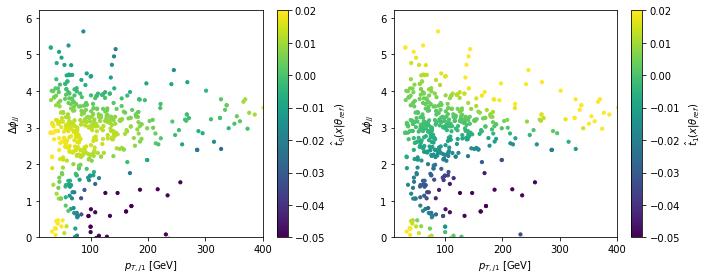

In [8]:
x = np.load('data/samples/x_test.npy')
skip=10

fig = plt.figure(figsize=(10,4))

for i in range(2):
    
    ax = plt.subplot(1,2,i+1)

    sc = plt.scatter(x[::skip,0], x[::skip,1], c=t_hat[::skip,i], s=10., cmap='viridis', vmin=-0.05, vmax=0.02)
    cbar = plt.colorbar(sc)

    cbar.set_label(r'$\hat{t}_' + str(i) + r'(x | \theta_{ref})$')
    plt.xlabel(r'$p_{T,j1}$ [GeV]')
    plt.ylabel(r'$\Delta \phi_{jj}$')
    plt.xlim(10.,400.)
    plt.ylim(0.,6.2)
    
plt.tight_layout()
plt.show()


In addition, we can use SALLY estimators to estimate the expected Fisher information.

In [9]:
fisher = FisherInformation('data/madminer_example_shuffled.h5', debug=False)

10:22  Loading data from data/madminer_example_shuffled.h5
10:22  Found 2 parameters:
10:22     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-10.0, 10.0))
10:22     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-10.0, 10.0))
10:22  Found 6 benchmarks:
10:22     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
10:22     w: CWL2 = 10.00, CPWL2 = 0.00e+00
10:22     morphing_basis_vector_2: CWL2 = 7.63, CPWL2 = -8.69e+00
10:22     morphing_basis_vector_3: CWL2 = -8.59e+00, CPWL2 = -8.65e+00
10:22     morphing_basis_vector_4: CWL2 = -5.88e+00, CPWL2 = 5.33
10:22     morphing_basis_vector_5: CWL2 = 2.84, CPWL2 = 8.99
10:22  Found 2 observables: pt_j1, delta_phi_jj
10:22  Found 101221 events
10:22  Found morphing setup with 6 components


In [10]:
fisher_information, _ = fisher.calculate_fisher_information_full_detector(
    theta=[0.,0.],
    model_file='models/sally',
    unweighted_x_sample_file='data/samples/x_test.npy',
    luminosity=300000.
)

print('Kinematic Fisher information after 300 ifb:\n{}'.format(fisher_information))

10:22  Evaluating rate Fisher information


Kinematic Fisher information after 300 ifb:
[[12.1804956   0.54140135]
 [ 0.54140135  4.21376079]]


We can visualize the Fisher information with contours:

/Users/johannbrehmer/anaconda3/envs/higgs_inference/lib/python3.6/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'label'
  s)
/Users/johannbrehmer/anaconda3/envs/higgs_inference/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


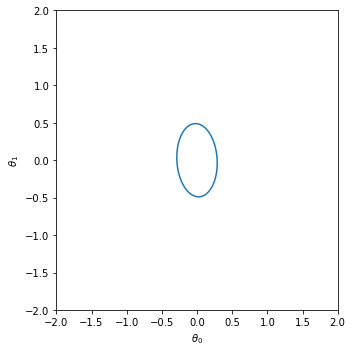

In [11]:
_ = plot_fisher_information_contours_2d(
    [fisher_information],
    xrange=(-2.,2.),
    yrange=(-2.,2.)
)

## 7b. Ensemble methods

Instead of using a single neural network to estimate the likelihood ratio, score, or Fisher information, we can use an ensemble of such estimators. That provides us with a more reliable mean prediction as well as a measure of the uncertainty. The class `madminer.ml.EnsembleForge` automates this process. Currently, it only supports SALLY estimators:

In [12]:
ensemble = EnsembleForge(estimators=5)

The `EnsembleForge` object has very similar functions as `MLForge`. In particular, we can train all estimators simultaneously with `train_all()` and save the ensemble to files:

In [13]:
ensemble.train_all(
    method='sally',
    x_filename='data/samples/x_train0.npy',
    t_xz0_filename='data/samples/t_xz_train0.npy',
    n_epochs=20,
    batch_size=256,
    validation_split=None
)

ensemble.save('models/sally_ensemble')

10:22  Training 5 estimators in ensemble
10:22  Training estimator 1 / 5 in ensemble
10:22  Starting training
10:22    Method:                 sally
10:22    Training data: x at data/samples/x_train0.npy
10:22                   t_xz (theta0) at  data/samples/t_xz_train0.npy
10:22    Features:               all
10:22    Method:                 sally
10:22    Hidden layers:          (100, 100)
10:22    Activation function:    tanh
10:22    Batch size:             256
10:22    Trainer:                amsgrad
10:22    Epochs:                 20
10:22    Learning rate:          0.001 initially, decaying to 0.0001
10:22    Validation split:       None
10:22    Early stopping:         True
10:22    Scale inputs:           True
10:22    Shuffle labels          False
10:22    Regularization:         None
10:22  Loading training data
10:22  Found 100000 samples with 2 parameters and 2 observables
10:22  Rescaling inputs
10:22  Creating model for method sally
10:22  Training model
10:22    Epoch 

Any evaluation of this ensemble will provide us with mean and variance of the predictions. Let's try that for the Fisher information:

In [14]:
fisher = FisherInformation('data/madminer_example_shuffled.h5', debug=False)

fisher_information_mean, fisher_information_covariance = fisher.calculate_fisher_information_full_detector(
    theta=[0.,0.],
    model_file='models/sally_ensemble',
    unweighted_x_sample_file='data/samples/x_test.npy',
    luminosity=300000.
)

10:25  Loading data from data/madminer_example_shuffled.h5
10:25  Found 2 parameters:
10:25     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-10.0, 10.0))
10:25     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-10.0, 10.0))
10:25  Found 6 benchmarks:
10:25     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
10:25     w: CWL2 = 10.00, CPWL2 = 0.00e+00
10:25     morphing_basis_vector_2: CWL2 = 7.63, CPWL2 = -8.69e+00
10:25     morphing_basis_vector_3: CWL2 = -8.59e+00, CPWL2 = -8.65e+00
10:25     morphing_basis_vector_4: CWL2 = -5.88e+00, CPWL2 = 5.33
10:25     morphing_basis_vector_5: CWL2 = 2.84, CPWL2 = 8.99
10:25  Found 2 observables: pt_j1, delta_phi_jj
10:25  Found 101221 events
10:25  Found morphing setup with 6 components
10:26  Evaluating rate Fisher information
10:26  Found ensemble with 5 estimators and expectations None


The covariance can be propagated to the Fisher distance contour plot easily:

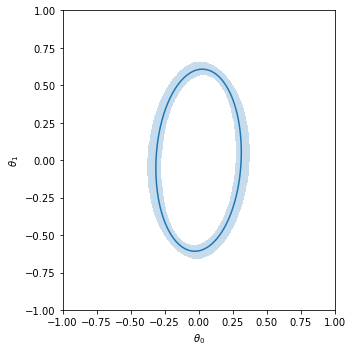

In [15]:
_ = plot_fisher_information_contours_2d(
    [fisher_information_mean],
    [fisher_information_covariance],
    xrange=(-1.,1.),
    yrange=(-1.,1.)
)

Confused? If you have questions, please have a look at the papers, the module documentation, or drop us an email!